In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import tplquad

In [2]:
# physical parameters

# Bohr radius
a0 = 0.529 # Å

# Vaccume permitivity
e_0 = 8.854e-42 # kg^-1 * Å^-3 * s^4 * A^2

# Elementary charge
e = 1.60217663e-19 # A * s 

# Carbon's mass ratio
Z = 12.01

# Lattice Spacing of the Graphene
d = 1.42 # Å

# Lattice constant of the Bravais
a = np.sqrt(3)*d

# 1[eV] = 1.6*10^(-19) [J]
# 1[J] = 1/1.6*10^(19)[eV]
# 1[J] = kg * m^2 * s^(-2) = 10^20 * kg * s^(-2) * Å^2

# So 1 [kg * s^(-2) * Å^2] = 1/16 [eV]


In [3]:
# Define the dot product

def k1a1(x,y):
    dot = a*((1/2)*x + np.sqrt(3)/2*y)
    return dot

def k2a2(x,y):
    dot = a*((-1/2)*x + np.sqrt(3)/2*y)
    return dot

# Define the matrix (Hamiltonian)
# Take a complex conjugate for the half of the matrix elements.

def matrix(x,y,eps0s,eps0p,sssigma,spsigma,ppsigma,pppi):
    
    I = np.zeros((8,8), dtype = 'complex_')
    I[0][0] = eps0p # (pz1, pz1)
    I[0][1] = pppi*(1 + np.exp(1j*k1a1(x,y)) + np.exp(1j*k2a2(x,y)) ) # (pz1,pz2)
    I[0][2] = 0 # (pz1, s1)
    I[0][3] = 0 # (pz1, s2)
    I[0][4] = 0 # (pz1, px1)
    I[0][5] = 0 # (pz1, px2)
    I[0][6] = 0 # (pz1, py1)
    I[0][7] = 0 # (pz1, py2)

    I[1][0] = np.conjugate(I[0][1]) 
    I[1][1] = eps0p # (pz2, pz2)
    I[1][2] = 0 # (pz2, s1)
    I[1][3] = 0 # (pz2, s2)
    I[1][4] = 0 # (pz2, px1)
    I[1][5] = 0 # (pz2, px2)
    I[1][6] = 0 # (pz2, py1)
    I[1][7] = 0 # (pz2, py2)
    

    I[2][0] = np.conjugate(I[0][2])
    I[2][1] = np.conjugate(I[1][2])
    I[2][2] = eps0s # (s1,s1)
    I[2][3] = sssigma*(1 + np.exp(1j*k1a1(x,y)) + np.exp(1j*k2a2(x,y)) ) # (s1, s2)
    I[2][4] = 0 # (s1, px1)
    I[2][5] = spsigma*(np.sqrt(3)/2)*np.exp(1j*k1a1(x,y)) + spsigma*(-np.sqrt(3)/2)*np.exp(1j*k2a2(x,y)) # (s1, px2)
    I[2][6] = 0 # (s1, py1)
    I[2][7] = spsigma*(-1) + spsigma*(1/2)*np.exp(1j*k1a1(x,y)) + spsigma*(1/2)*np.exp(1j*k2a2(x,y)) # (s1, py2)

    I[3][0] = np.conjugate(I[0][3])
    I[3][1] = np.conjugate(I[1][3])
    I[3][2] = np.conjugate(I[2][3])
    I[3][3] = eps0s # (s2, s2)
    I[3][4] = spsigma*(-np.sqrt(3)/2)*np.exp(-1j*k1a1(x,y)) + spsigma*(np.sqrt(3)/2)*np.exp(-1j*k2a2(x,y)) # (s2, px1)
    I[3][5] = 0 # (s2, px2)
    I[3][6] = spsigma*1 + spsigma*(-1/2)*np.exp(-1j*k1a1(x,y)) + spsigma*(-1/2)*np.exp(-1j*k2a2(x,y)) # (s2, py1)
    I[3][7] = 0 # (s2, py2)

    I[4][0] = np.conjugate(I[0][4])
    I[4][1] = np.conjugate(I[1][4])
    I[4][2] = np.conjugate(I[2][4])
    I[4][3] = np.conjugate(I[3][4])
    I[4][4] = eps0p # (px1, px1)
    I[4][5] = pppi + ppsigma*(3/4)*np.exp(1j*k1a1(x,y)) + pppi*(1/4)*np.exp(1j*k1a1(x,y)) + ppsigma*(3/4)*np.exp(1j*k2a2(x,y)) + pppi*(1/4)*np.exp(1j*k2a2(x,y)) # (px1, px2)
    I[4][6] = 0 # (px1, py1)
    I[4][7] = ppsigma*(np.sqrt(3)/4)*np.exp(1j*k1a1(x,y)) + pppi*(-np.sqrt(3)/4)*np.exp(1j*k1a1(x,y)) + ppsigma*(-np.sqrt(3)/4)*np.exp(1j*k2a2(x,y)) + pppi*(np.sqrt(3)/4)*np.exp(1j*k2a2(x,y)) # (px1, py2)

    I[5][0] = np.conjugate(I[0][5])
    I[5][1] = np.conjugate(I[1][5])
    I[5][2] = np.conjugate(I[2][5])
    I[5][3] = np.conjugate(I[3][5])
    I[5][4] = np.conjugate(I[4][5])
    I[5][5] = eps0p # (px2, px2)
    I[5][6] = ppsigma*(np.sqrt(3)/4)*np.exp(-1j*k1a1(x,y)) + pppi*(-np.sqrt(3)/4)*np.exp(-1j*k1a1(x,y)) + ppsigma*(-np.sqrt(3)/4)*np.exp(-1j*k2a2(x,y)) + pppi*(np.sqrt(3)/4)*np.exp(-1j*k2a2(x,y)) # (px2, py1)
    I[5][7] = 0 # (px2, py2)
    
    I[6][0] = np.conjugate(I[0][6])
    I[6][1] = np.conjugate(I[1][6])
    I[6][2] = np.conjugate(I[2][6])
    I[6][3] = np.conjugate(I[3][6])
    I[6][4] = np.conjugate(I[4][6])
    I[6][5] = np.conjugate(I[5][6])
    I[6][6] = eps0p # (py1, py1)
    I[6][7] = ppsigma + ppsigma*(1/4)*np.exp(1j*k1a1(x,y)) + pppi*(3/4)*np.exp(1j*k1a1(x,y)) + ppsigma*(1/4)*np.exp(1j*k2a2(x,y)) + pppi*(3/4)*np.exp(1j*k2a2(x,y)) # (py1, py2)
    
    I[7][0] = np.conjugate(I[0][7])
    I[7][1] = np.conjugate(I[1][7])
    I[7][2] = np.conjugate(I[2][7])
    I[7][3] = np.conjugate(I[3][7])
    I[7][4] = np.conjugate(I[4][7])
    I[7][5] = np.conjugate(I[5][7])
    I[7][6] = np.conjugate(I[6][7])
    I[7][7] = eps0p # (py2, py2)
    
    return I


In [4]:
# s-orbital
def s_orbit(x, y, z, a0 = a0, Z = Z):
    r = np.sqrt(x**2 + y**2 + z**2 + 1e-20)
    psi = 1/np.sqrt(np.pi) * (Z/(2*a0))**(3/2) * (1 - Z*r/(2*a0)) * np.exp(-Z*r/(2*a0))
    return psi

# pz-orbital
def pz_orbit(x, y, z, a0 = a0, Z = Z):
    r = np.sqrt(x**2 + y**2 + z**2 + 1e-20)
    cos_theta = z/(r+1e-20)
    psi = 1/(2*np.sqrt(np.pi)) * (Z/(2*a0))**(3/2) * (Z*r/a0) * np.exp(-Z*r/(2*a0)) * cos_theta
    return psi
    
# px-orbital
def px_orbit(x, y, z, a0 = a0, Z = Z):
    r = np.sqrt(x**2 + y**2 + z**2 + 1e-20)
    R = np.sqrt(x**2 + y**2 + 1e-40)
    sin_theta = R/(r+1e-20)
    cos_phi = x/(r*sin_theta)
    psi = - 1/(2*np.sqrt(np.pi)) * (Z/(2*a0))**(3/2) * (Z*r/a0) * np.exp(-Z*r/(2*a0)) * sin_theta * cos_phi
    return psi

# py-orbital
def py_orbit(x, y, z, a0 = a0, Z = Z):
    r = np.sqrt(x**2 + y**2 + z**2 + 1e-20)
    R = np.sqrt(x**2 + y**2 + 1e-40)
    sin_theta = R/(r+1e-20)
    sin_phi = y/(r*sin_theta)
    psi = - 1/(2*np.sqrt(np.pi)) * (Z/(2*a0))**(3/2) * (Z*r/a0) * np.exp(-Z*r/(2*a0)) * sin_theta * sin_phi
    return psi

In [5]:
# Coulomb potential
def deltaU(x, y, z, Z = Z): # Spherically symmetric
    r = np.sqrt(x**2 + y**2 + z**2 + 1e-20)
    potential = - 1/(4*np.pi*e_0)*Z*e**2/np.abs(r)
    return potential

In [6]:
'''# Calculate the hopping integrations.
L = 4*a0 + d
func = lambda x,y,z:s_orbit(x, y, z)* deltaU(x - d, y, z)* s_orbit(x - d, y, z)
sssigmaintegral = tplquad(func, -L, L, -L, L, -L, L)
sssigma = sssigmaintegral[0]/16
print("sssigma = ", sssigma, "[eV]")

L = 4*a0 + d
func = lambda x,y,z:s_orbit(x, y, z)* deltaU(x - d, y, z)* px_orbit(x - d, y, z)
spsigmaintegral = tplquad(func, -L, L, -L, L, -L, L)
spsigma = spsigmaintegral[0]/16
print("spsigma = ", spsigma, "[eV]")

L = 4*a0 + d
func = lambda x,y,z:px_orbit(x, y, z)* deltaU(x - d, y, z)* px_orbit(x - d, y, z)
ppsigmaintegral = tplquad(func, -L, L, -L, L, -L, L)
ppsigma = ppsigmaintegral[0]/16
print("ppsigma = ", ppsigma, "[eV]")

L = 4*a0 + d
func = lambda x,y,z:pz_orbit(x, y, z)* deltaU(x - d, y, z)* pz_orbit(x - d, y, z)
pppiintegral = tplquad(func, -L, L, -L, L, -L, L)
pppi = pppiintegral[0]/16
print("pppi = " ,pppi, "[eV]")

'''

sssigma = - 5.2
spsigma = - 3.4
ppsigma = - 2.5
pppi = - 1.1

In [7]:
# Set the energy of atomic orbital as 0 [eV].
eps0s = -40.8 #[eV]
eps0p = -40.8 #[eV]

In [8]:
# Solve the eigenvalue equation along a certain path in Brillouin Zone.
N = 1000
x_values1 = np.linspace(0, 2*np.pi/(3*a), N)
y_values1 = np.sqrt(3)*x_values1

x_values2 = np.linspace(2*np.pi/(3*a), np.pi/(a), int(N/2))
y_values2 = -np.sqrt(3)*x_values2 + 4*np.pi/(np.sqrt(3)*a)*np.ones(int(N/2))

x_values3 = np.linspace(0, np.pi/(a), int(N*2/np.sqrt(3)))
x_values3 = x_values3[::-1]
y_values3 = 1/np.sqrt(3)*x_values3 
# Those are the distance of the path!! not x axis!
x_values1plot = np.linspace(0, 4*np.pi/(3*a), N)
x_values2plot = np.linspace(0, 2*np.pi/(3*a), int(N/2)) + 4*np.pi/(3*a)*np.ones(int(N/2))
x_values3plot = np.linspace(0, 2*np.pi/(np.sqrt(3)*a), int(N*2/np.sqrt(3))) + (4*np.pi/(3*a)+2*np.pi/(3*a))*np.ones(int(N*2/np.sqrt(3)))

reciprocalpath = np.concatenate([x_values1plot, x_values2plot[1::], x_values3plot[1::]])

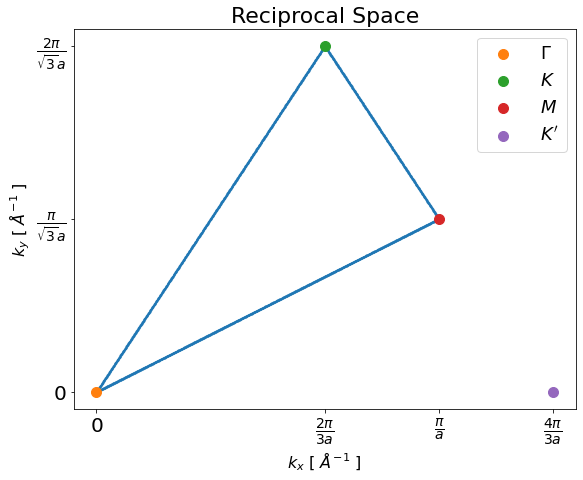

In [9]:
#Brillouin Zoneの軌跡をプロットする！！
figure = plt.figure(figsize = (9,7))
axes = figure.gca()

x_values = np.concatenate([x_values1, x_values2[1::], x_values3[1::]])
y_values = np.concatenate([y_values1, y_values2[1::], y_values3[1::]])

axes.scatter(x_values, y_values, s = 1)
axes.scatter(x_values1[0],y_values1[0] , s = 100, label = " $ \Gamma $ ")
axes.scatter(x_values2[0],y_values2[0] , s = 100, label = " $ K $ ")
axes.scatter(x_values2[-1],y_values2[-1] , s = 100, label = " $ M $ ")
axes.scatter(4*np.pi/(3*a), 0, s = 100, label = " $ K' $ ")


axes.set_title("Reciprocal Space", fontsize = 22)

axes.set_xlabel("$k_{x}~[~Å^{-1}~]$", fontsize = 16)
axes.set_xticks([0, 2*np.pi/(3*a), np.pi/(a),4*np.pi/(3*a)])
ticks = ["$0$", r"$\frac{2 \pi}{3a}$", r"$\frac{\pi}{a}$",r"$\frac{4 \pi}{3a}$" ]
axes.set_xticklabels(ticks,fontsize = 20)

axes.set_ylabel("$k_{y}~[~Å^{-1}~]$", fontsize = 16)
axes.set_yticks([0, np.pi/(np.sqrt(3)*a), 2*np.pi/(np.sqrt(3)*a)])
ticks = [r"$0$", r"$\frac{\pi}{ \sqrt{3} a}$", r"$\frac{2 \pi}{ \sqrt{3} a}$"]
axes.set_yticklabels(ticks,fontsize = 20)

axes.legend(fontsize = 18)

In [10]:
band = []
for i,j in zip(x_values1,y_values1):
    eigen1 = np.linalg.eigvalsh(matrix(i,j,eps0s,eps0p,sssigma,spsigma,ppsigma,pppi))
    eigen = eigen1[0]
    band.append(eigen1)
    
for i,j in zip(x_values2[1::],y_values2[1::]):
    eigen1 = np.linalg.eigvalsh(matrix(i,j,eps0s,eps0p,sssigma,spsigma,ppsigma,pppi))
    eigen = eigen1[0]
    band.append(eigen1)
    
for i,j in zip(x_values3[1::],y_values3[1::]):
    eigen1 = np.linalg.eigvalsh(matrix(i,j,eps0s,eps0p,sssigma,spsigma,ppsigma,pppi))
    eigen = eigen1[0]
    band.append(eigen1)

# Transpose to plot
bandT = np.transpose(band)

No handles with labels found to put in legend.


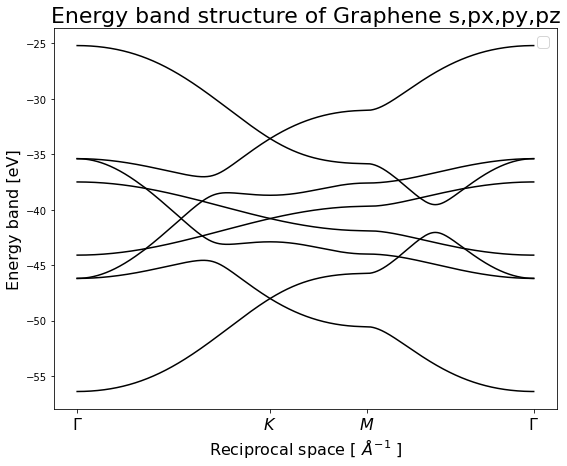

In [11]:
# Make a plot of the band structure.
fig1 = plt.figure(figsize = (9,7))
ax = fig1.gca()

for i in range(8):
    ax.plot(reciprocalpath, bandT[i], color = "black") 

'''    
ax.plot([0, 0], [-bandT[0][0], bandT[0][0]],label = "$ \Gamma $", linewidth = 1)
ax.plot([4*np.pi/(3*a), 4*np.pi/(3*a)], [-bandT[0][0], bandT[0][0]],label = "K", linewidth = 1)
ax.plot([2*np.pi/(a), 2*np.pi/(a)], [-bandT[0][0], bandT[0][0]],label = "M", linewidth = 1)

'''

ax.set_title("Energy band structure of Graphene s,px,py,pz", fontsize = 22)
ax.set_xlabel("Reciprocal space [ $ Å^{-1} $ ]", fontsize = 16)
ax.set_ylabel("Energy band [eV]", fontsize = 16)

ticks = ["$ \Gamma $", "$ K $", "$ M $", "$ \Gamma $"]
ax.set_xticks([0, 4*np.pi/(3*a), 2*np.pi/(a), (2+2/np.sqrt(3))*np.pi/(a) ])
ax.set_xticklabels(ticks,fontsize = 16)
ax.legend(fontsize = 15)

from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('Energy band calculation of Graphene s,px,py,pz.pdf')
pdf.savefig(figure)
pdf.savefig(fig1)
pdf.close()

